# Transfer Learning

In [1]:
!wget http://ivan-sipiran.com/downloads/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-11-07 16:07:33--  http://ivan-sipiran.com/downloads/hymenoptera_data.zip
Resolving ivan-sipiran.com (ivan-sipiran.com)... 66.96.149.31
Connecting to ivan-sipiran.com (ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  92.7MB/s    in 0.5s    

2020-11-07 16:07:34 (92.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymen

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

device = ('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Cargando el dataset

In [3]:
train_dataset = torchvision.datasets.ImageFolder('hymenoptera_data/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))
test_dataset = torchvision.datasets.ImageFolder('hymenoptera_data/val',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

print(train_dataset)

class_names = train_dataset.classes

print(f'class_names={class_names}')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
class_names=['ants', 'bees']


## 2. Mostrando un batch

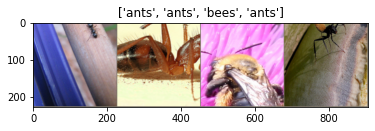

In [4]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3. Entrenamiento

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)
    
    # Entrenamiento

    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
      
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
      
    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accucary: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

## 4. Fine Tuning

Funciona mejor para otros procesos extras (no solo clasificación).

In [6]:
ft_model = models.resnet18(pretrained=True)
print(ft_model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [7]:
ft_model.fc = nn.Linear(512, 2)
ft_model = ft_model.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)
ft_model = train_model(ft_model, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.5443 Acc: 0.7049
Val Loss: 0.1892 Acc: 0.9412
Epoch 1/24
----------
Train Loss: 0.4233 Acc: 0.8402
Val Loss: 0.6030 Acc: 0.8039
Epoch 2/24
----------
Train Loss: 0.5865 Acc: 0.7910
Val Loss: 0.2770 Acc: 0.9150
Epoch 3/24
----------
Train Loss: 0.5773 Acc: 0.7623
Val Loss: 0.3049 Acc: 0.8889
Epoch 4/24
----------
Train Loss: 0.4464 Acc: 0.8033
Val Loss: 0.2341 Acc: 0.9346
Epoch 5/24
----------
Train Loss: 0.3533 Acc: 0.8402
Val Loss: 0.2059 Acc: 0.9477
Epoch 6/24
----------
Train Loss: 0.4566 Acc: 0.8484
Val Loss: 0.3238 Acc: 0.8627
Epoch 7/24
----------
Train Loss: 0.2792 Acc: 0.8811
Val Loss: 0.2394 Acc: 0.8889
Epoch 8/24
----------
Train Loss: 0.3802 Acc: 0.8361
Val Loss: 0.2593 Acc: 0.8693
Epoch 9/24
----------
Train Loss: 0.2931 Acc: 0.8770
Val Loss: 0.2287 Acc: 0.8824
Epoch 10/24
----------
Train Loss: 0.2937 Acc: 0.8811
Val Loss: 0.2505 Acc: 0.9085
Epoch 11/24
----------
Train Loss: 0.3102 Acc: 0.8607
Val Loss: 0.2393 Acc: 0.8954
Epoch 12/24
--

In [ ]:
# Mostrando las predicciones

def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)


visualize_model(ft_model)

## 5. Freeze

Funciona mejor para solo clasificación.

COMPLETAR

Linea 6 define la última capa nuevamente (se desactiva el cálculo de gradiente). En este se calcula una de las dos clases. 

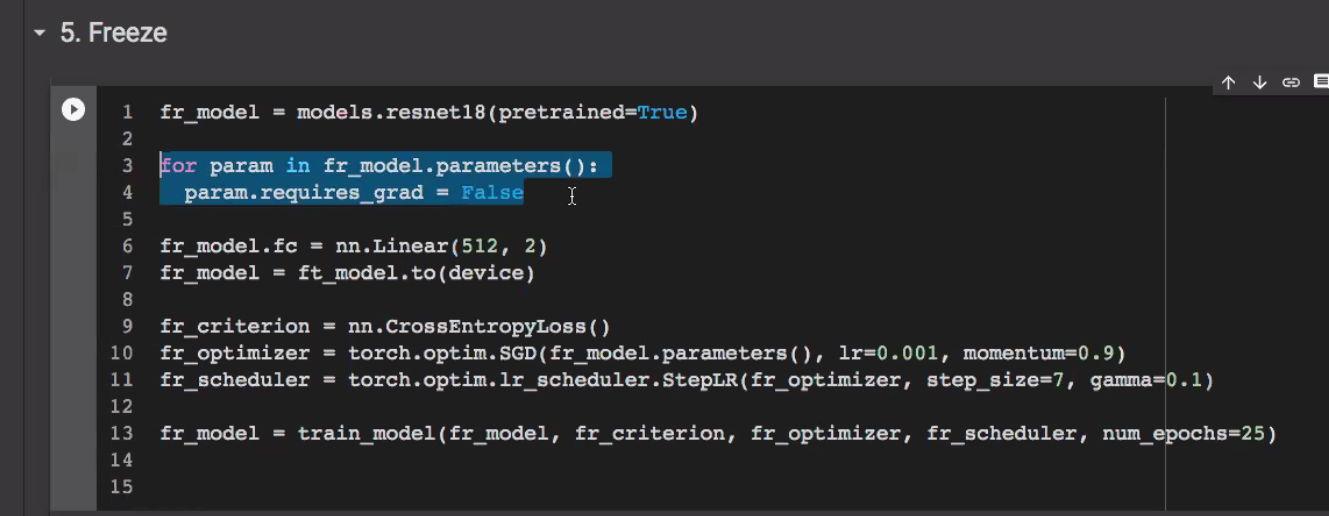
